In [40]:
import pandas as pd
import glob
import os
import netCDF4 as nc4
import sys
sys.path.append('/glade/u/home/adamhb/Earth-System-Model-Tools')
import esm_tools
import re
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
np.set_printoptions(threshold=1000)

In [7]:
def extract_case_number(filename):
    # Regular expression pattern to find two digits between "_" and ".csv"
    pattern = r'_(\d{2})\.csv'
    
    # Search for the pattern in the filename
    match = re.search(pattern, filename)
    
    # If a match is found, return the first group (the two digits)
    if match:
        return match.group(1)  # Returns the two digits as a string
    else:
        return None  # Returns None if no match is found

def make_histograms_of_metrics(df):

    metrics = df.columns[1:]
    
    for metric in metrics:
        plt.hist(df[metric], bins=25, alpha=0.9, color='white', edgecolor='black', label = "Model")
        if metric in vln.keys():
            plt.xlabel(vln[metric])
        else:
            plt.xlabel(metric)
        plt.ylabel("Number of ensemble members")
        plt.legend()
        plt.tight_layout()
        plt.show()

In [134]:
def extract_variable_from_netcdf(file_path, variable_name,index):
    """
    Extract a variable from a NetCDF file.

    Parameters:
    - file_path: The path to the NetCDF file.
    - variable_name: The name of the variable to extract.

    Returns:
    - The extracted variable data.
    """
    with nc4.Dataset(file_path, 'r') as dataset:
        # Check if the variable exists in the dataset
        if variable_name in dataset.variables:
            variable_data = dataset.variables[variable_name]
            #print("Variable shape",len(variable_data.shape))
            if len(variable_data.shape) == 0:
                return variable_data[:].data.item()
            if len(variable_data.shape) == 1:
                return variable_data[:].data[index]
            if len(variable_data.shape) == 2:
                return variable_data[:].data[0,index]
        else:
            raise ValueError(f"'{variable_name}' not found in the NetCDF file.")

In [147]:
param_subdirs

['/glade/u/home/adamhb/ahb_params/fates_api_25/ensembles/afterBugFix_1280_041923_01',
 '/glade/u/home/adamhb/ahb_params/fates_api_25/ensembles/afterBugFix_1280_041923_04',
 '/glade/u/home/adamhb/ahb_params/fates_api_25/ensembles/afterBugFix_1280_041923_05',
 '/glade/u/home/adamhb/ahb_params/fates_api_25/ensembles/afterBugFix_1280_041923_06',
 '/glade/u/home/adamhb/ahb_params/fates_api_25/ensembles/afterBugFix_1280_041923_08',
 '/glade/u/home/adamhb/ahb_params/fates_api_25/ensembles/afterBugFix_1280_041923_09',
 '/glade/u/home/adamhb/ahb_params/fates_api_25/ensembles/afterBugFix_1280_041923_10']

In [133]:
param_ranges = pd.read_csv('/glade/u/home/adamhb/california-fates/parameter_ranges/param_range_archive/param_ranges_040524.csv')
param_ranges = param_ranges.loc[param_ranges['param'] != 'fates_leaf_slamax']
params = np.array(param_ranges['param'])
pfts = param_ranges['pft']
indices = np.maximum(np.array(pfts) - 1,0)
param_index_names = [params[i] + "_" + str(indices[i]) for i in list(range(len(params)))]
param_subdirs = [f'/glade/u/home/adamhb/ahb_params/fates_api_25/ensembles/afterBugFix_1280_041923_{case_number}' for case_number in ['01','04','05','06','08','09','10']]
inst_tags = esm_tools.inst_to_tag(list(range(1,129)))
param_file_names = [f'ca_5pfts_100523_{tag}.nc' for tag in inst_tags]

In [150]:
param_subdirs

['/glade/u/home/adamhb/ahb_params/fates_api_25/ensembles/afterBugFix_1280_041923_01',
 '/glade/u/home/adamhb/ahb_params/fates_api_25/ensembles/afterBugFix_1280_041923_04',
 '/glade/u/home/adamhb/ahb_params/fates_api_25/ensembles/afterBugFix_1280_041923_05',
 '/glade/u/home/adamhb/ahb_params/fates_api_25/ensembles/afterBugFix_1280_041923_06',
 '/glade/u/home/adamhb/ahb_params/fates_api_25/ensembles/afterBugFix_1280_041923_08',
 '/glade/u/home/adamhb/ahb_params/fates_api_25/ensembles/afterBugFix_1280_041923_09',
 '/glade/u/home/adamhb/ahb_params/fates_api_25/ensembles/afterBugFix_1280_041923_10']

In [151]:
param_data = np.zeros((128 * 7,len(params)))
row = -1
for param_subdir in param_subdirs:
    print("Working on",param_subdir)
    for file in param_file_names:
        file_path = os.path.join(param_subdir,file)
        row = row  + 1
        col = -1
        for param,index in zip(params,indices):
            col = col + 1
            param_data[row,col] = extract_variable_from_netcdf(file_path,param,index)

Working on /glade/u/home/adamhb/ahb_params/fates_api_25/ensembles/afterBugFix_1280_041923_01
Working on /glade/u/home/adamhb/ahb_params/fates_api_25/ensembles/afterBugFix_1280_041923_04
Working on /glade/u/home/adamhb/ahb_params/fates_api_25/ensembles/afterBugFix_1280_041923_05
Working on /glade/u/home/adamhb/ahb_params/fates_api_25/ensembles/afterBugFix_1280_041923_06
Working on /glade/u/home/adamhb/ahb_params/fates_api_25/ensembles/afterBugFix_1280_041923_08
Working on /glade/u/home/adamhb/ahb_params/fates_api_25/ensembles/afterBugFix_1280_041923_09
Working on /glade/u/home/adamhb/ahb_params/fates_api_25/ensembles/afterBugFix_1280_041923_10


In [161]:
case_num_inst_id = [case_num + "_" + inst_tag for case_num in ['01','04','05','06','08','09','10'] for inst_tag in inst_tags]
param_df = pd.DataFrame(param_data,index = case_num_inst_id, columns = param_index_names)
param_df = param_df.reset_index().rename(columns={'index': 'case_num_inst_id'})

## Load data

In [171]:
path_to_metrics = '/glade/work/adamhb/processed_output/CZ2_equilibrium_041924_XX_-17e2acb6a_FATES-1449c787'
files = glob.glob(os.path.join(path_to_metrics,'*'))

df = pd.DataFrame()
for file in files:
    tmp = pd.read_csv(file, dtype={'inst_tag':str})
    to_drop = tmp.columns[0]
    tmp.drop(to_drop,axis=1,inplace=True)
    case_number = extract_case_number(file)
    tmp['case_number'] = case_number
    df = pd.concat([df,tmp],axis = 0)

print(len(df), "ensemble members analyzed.")
df['case_num_inst_id'] =  df['case_number'] + "_" + df['inst_tag']

# path_to_ensemble_output = '/home/adam/cloud/gdrive/postdoc/simulation_output/conifer-allom-092123_5pfts_-17e2acb6a_FATES-55794e61/ensemble_output_conifer-allom-092123_5pfts_-17e2acb6a_FATES-55794e61v2.csv'
# df = pd.read_csv(path_to_ensemble_output)
# df = df.drop([df.columns[0]],axis=1)

896 ensemble members analyzed.


In [175]:
df_all = pd.merge(df,param_df,on = 'case_num_inst_id')

## Get correlation coefficients with ShannonE

In [176]:
# shannon_correlation = df.corrwith(df['ShannonE'])
# cor_df = pd.DataFrame(shannon_correlation)
# cor_df.columns = ["cor"]
# cor_df["abs_cor"] = abs(cor_df["cor"])
# cor_df.sort_values("abs_cor",ascending=False)

def get_corr(df,var):
    var_correlation = df.corrwith(df[var])
    cor_df = pd.DataFrame(var_correlation)
    cor_df.columns = ["cor"]
    cor_df["abs_cor"] = abs(cor_df["cor"])
    return cor_df.sort_values("abs_cor",ascending=False)

get_corr(df_all,"BA_oak")

,cor,abs_cor
BA_oak,1.000000,1.000000
Pct_oak_cover_canopy,0.791890,0.791890
ResproutD_oak,0.503245,0.503245
Pct_conifer_cover_canopy,-0.376332,0.376332
fates_leaf_vcmax25top_4,0.376306,0.376306
fates_leaf_slatop_4,0.363495,0.363495
Pct_shrub_cover_canopy,-0.301989,0.301989
BA_conifer,-0.295947,0.295947
Pct_shrub_cover,-0.290748,0.290748
Pct_cedar_cover_canopy,-0.276545,0.276545


(array([ 5., 21., 40., 18.,  7.,  8.,  4.,  3.,  0.,  2.]),
 array([0.007 , 0.0277, 0.0484, 0.0691, 0.0898, 0.1105, 0.1312, 0.1519,
        0.1726, 0.1933, 0.214 ]),
 <BarContainer object of 10 artists>)

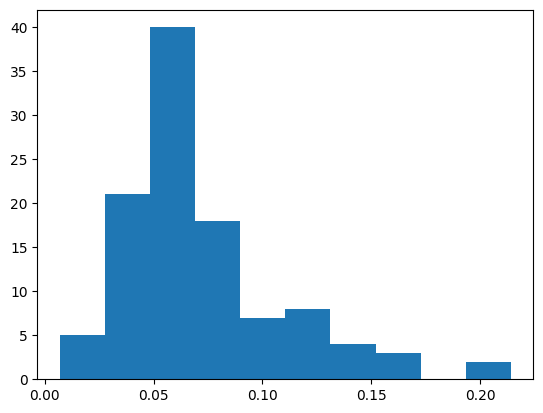

In [6]:
plt.hist(df.Burned_area)

(array([ 8.,  8.,  6., 10., 10., 11., 18., 17., 15.,  5.]),
 array([ 3.01507538, 11.75466373, 20.49425208, 29.23384044, 37.97342879,
        46.71301714, 55.45260549, 64.19219385, 72.9317822 , 81.67137055,
        90.4109589 ]),
 <BarContainer object of 10 artists>)

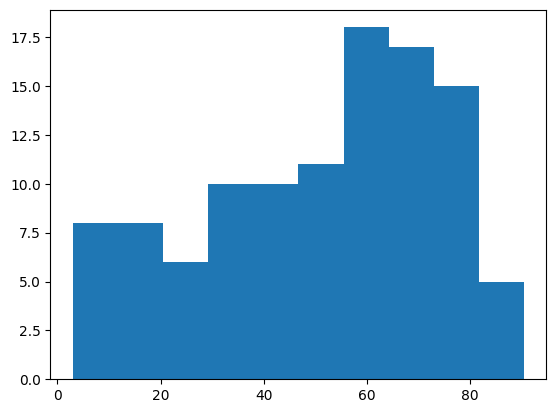

In [7]:
plt.hist(df.Pct_high_severity_1700)

Text(0, 0.5, 'PHS 1700 Kw m-1 s-1')

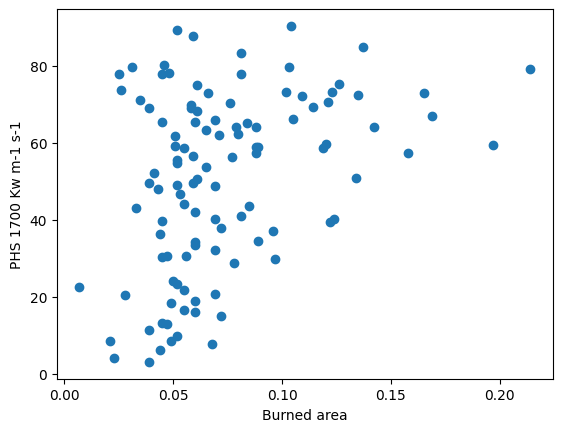

In [8]:
plt.scatter(df["Burned_area"],df['Pct_high_severity_1700'])
plt.xlabel("Burned area")
plt.ylabel("PHS 1700 Kw m-1 s-1")

## Visualize affect of fire and fuel on ShannonE

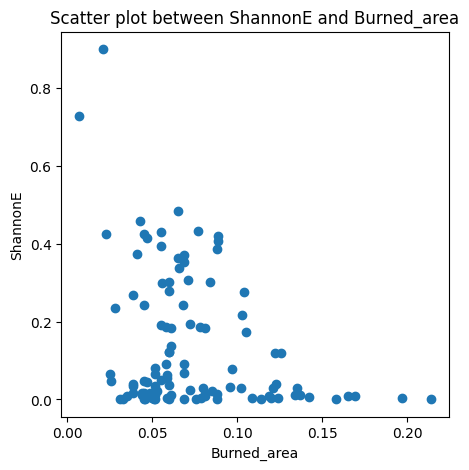

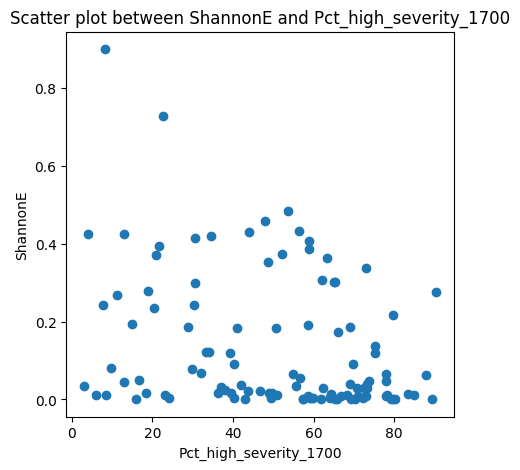

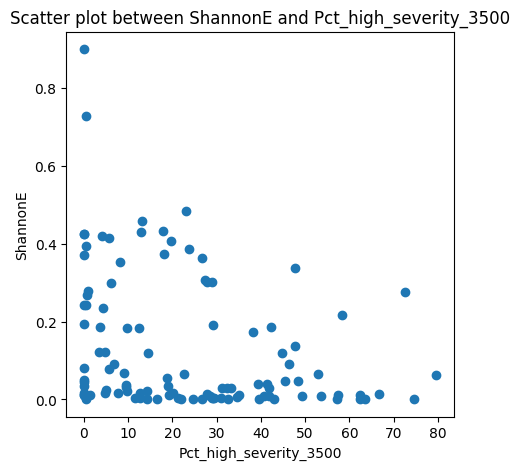

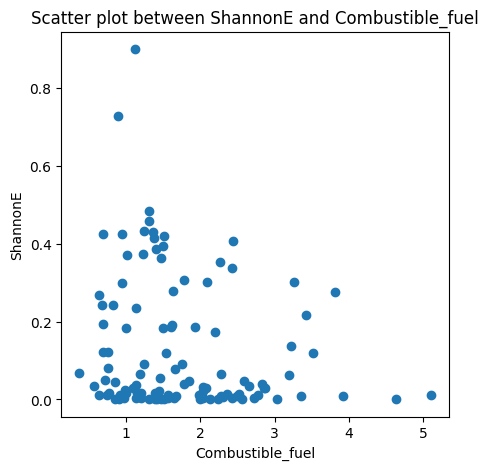

In [9]:
y_variable="ShannonE"
for col in ["Burned_area","Pct_high_severity_1700","Pct_high_severity_3500","Combustible_fuel"]:
    plt.figure(figsize=(5, 5))
    plt.scatter(df[col],df[y_variable])
    plt.title(f'Scatter plot between {y_variable} and {col}')
    plt.xlabel(col)
    plt.ylabel(y_variable)
    plt.show()

## What drives burned area?

In [10]:
shannon_correlation = df.corrwith(df['Burned_area'])
cor_df = pd.DataFrame(shannon_correlation)
cor_df.columns = ["cor"]
cor_df["abs_cor"] = abs(cor_df["cor"])
cor_df.sort_values("abs_cor",ascending=False)

,cor,abs_cor
Burned_area,1.000000,1.000000
Combustible_fuel,0.633682,0.633682
BA_oak,-0.603613,0.603613
Pct_shrub_cover_canopy,0.601939,0.601939
fates_fire_nignitions_0,0.577167,0.577167
NPP,0.569432,0.569432
Pct_shrub_cover,0.568394,0.568394
BA_shrub,0.566745,0.566745
AGB,-0.502304,0.502304
Pct_high_severity_1700,0.368822,0.368822


## What drives fire severity?

In [11]:
shannon_correlation = df.corrwith(df['Pct_high_severity_1700'])
cor_df = pd.DataFrame(shannon_correlation)
cor_df.columns = ["cor"]
cor_df["abs_cor"] = abs(cor_df["cor"])
cor_df.sort_values("abs_cor",ascending=False)

,cor,abs_cor
Pct_high_severity_1700,1.000000,1.000000
Pct_high_severity_3500,0.918184,0.918184
Combustible_fuel,0.738948,0.738948
NPP,0.673967,0.673967
fates_frag_maxdecomp_0,-0.622646,0.622646
fates_leaf_vcmax25top_5,0.566572,0.566572
Burned_area,0.368822,0.368822
fates_leaf_slatop_5,0.349321,0.349321
fates_turnover_leaf_5,-0.317704,0.317704
ShannonE,-0.309502,0.309502


## What drives combustible fuel?

In [12]:
shannon_correlation = df.corrwith(df['Combustible_fuel'])
cor_df = pd.DataFrame(shannon_correlation)
cor_df.columns = ["cor"]
cor_df["abs_cor"] = abs(cor_df["cor"])
cor_df.sort_values("abs_cor",ascending=False)

,cor,abs_cor
Combustible_fuel,1.000000,1.000000
NPP,0.812265,0.812265
Pct_high_severity_3500,0.749503,0.749503
Pct_high_severity_1700,0.738948,0.738948
BA_shrub,0.643895,0.643895
Burned_area,0.633682,0.633682
Pct_shrub_cover,0.625506,0.625506
Pct_shrub_cover_canopy,0.617682,0.617682
BA,0.612705,0.612705
fates_frag_maxdecomp_0,-0.541428,0.541428


## What drives high burned area with low fire severity

In [13]:
df['BA_to_PHS_1700'] = df['Burned_area'] / df['Pct_high_severity_1700']

In [14]:
shannon_correlation = df.corrwith(df['BA_to_PHS_1700'])
cor_df = pd.DataFrame(shannon_correlation)
cor_df.columns = ["cor"]
cor_df["abs_cor"] = abs(cor_df["cor"])
cor_df.sort_values("abs_cor",ascending=False)

,cor,abs_cor
BA_to_PHS_1700,1.000000,1.000000
Pct_high_severity_1700,-0.650921,0.650921
fates_fire_nignitions_0,0.527431,0.527431
Pct_high_severity_3500,-0.468672,0.468672
fates_frag_maxdecomp_0,0.394337,0.394337
NPP,-0.346415,0.346415
AGB,-0.323640,0.323640
fates_allom_d2ca_coefficient_max_5,0.311719,0.311719
Combustible_fuel,-0.301402,0.301402
fates_leaf_vcmax25top_5,-0.297020,0.297020


In [179]:
# my_metrics = ["BA","AGB","TreeStemD","ShannonE","NPP","FailedPFTs",
#               "Burned_area","Pct_high_severity_1700","Pct_high_severity_3500",
#               "Pct_shrub_cover_canopy","Pct_shrub_cover",
#               "Combustible_fuel"]

to_drop = ["BA_trees","AGCD","TreeStemD","ShannonE","NPP","FailedPFTs"]
to_drop.extend(list(df.filter(regex='BA').columns))
to_drop

['BA_trees',
 'AGCD',
 'TreeStemD',
 'ShannonE',
 'NPP',
 'FailedPFTs',
 'BA_conifer',
 'BA_trees',
 'BA_pine',
 'BA_cedar',
 'BA_fir',
 'BA_shrub',
 'BA_oak']

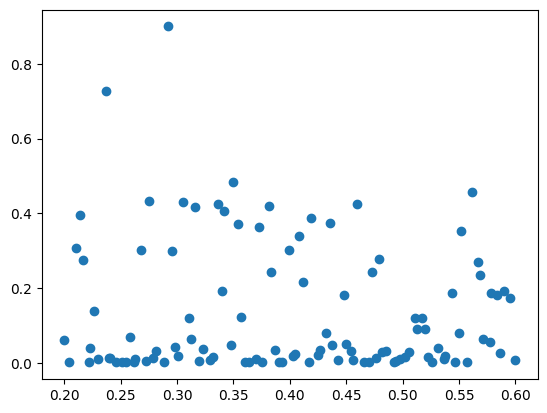

In [21]:
plt.scatter(df['fates_fire_frac_resprout_4'],df['ShannonE'])

## Fit Lasso Regression

In [193]:
y = df_all['BA_oak']

# X = df_all.drop(['AGCD', 'BA_conifer', 'BA_trees', 'BA_pine', 'BA_cedar',
#        'BA_fir', 'BA_shrub', 'BA_oak', 'TreeStemD'],axis = 1)

X = df_all.loc[:, df_all.columns.str.contains('fates',case=False)]

# Standardize the features (important for Lasso)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.05, random_state=0)

# Initialize Lasso model
# You can change the alpha parameter, higher values give stronger regularization
lasso = Lasso(alpha=0.01, max_iter=10000)

# Fit the model
lasso.fit(X_train, y_train)

print(f"R-squared on training data: {lasso.score(X_train, y_train):.2f}")

# Predict on the test data
y_pred = lasso.predict(X_test)

# Calculate the mean squared error of the predictions
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on test data: {mse:.2f}")

# View the coefficients of the model
coef = pd.DataFrame()
coef['Feature'] = X.columns
coef['Coefficient'] = lasso.coef_
#print(coef)

R-squared on training data: 0.48
Mean Squared Error on test data: 1.66


In [194]:
# After computing the coefficients
coef['Abs_Coefficient'] = coef['Coefficient'].abs()  # Add a column for the absolute values
coef_sorted = coef.sort_values(by='Abs_Coefficient', ascending=False).reset_index(drop=True)  # Sort the DataFrame

# Now, coef_sorted is your sorted DataFrame
print(coef_sorted)

                                     Feature   Coefficient  Abs_Coefficient
0                    fates_leaf_vcmax25top_4  5.205634e-01     5.205634e-01
1                        fates_leaf_slatop_4  5.118273e-01     5.118273e-01
2                    fates_fire_nignitions_0 -3.899916e-01     3.899916e-01
3                      fates_turnover_leaf_4  2.273155e-01     2.273155e-01
4                     fates_frag_maxdecomp_0  2.060416e-01     2.060416e-01
5                        fates_stoich_nitr_4 -1.363585e-01     1.363585e-01
6         fates_allom_d2ca_coefficient_max_4  1.307524e-01     1.307524e-01
7                        fates_leaf_slatop_3 -8.982166e-02     8.982166e-02
8                  fates_fire_drying_ratio_0  8.744454e-02     8.744454e-02
9          fates_recruit_seed_alloc_mature_3 -8.342325e-02     8.342325e-02
10           fates_mort_ip_size_senescence_3 -8.134095e-02     8.134095e-02
11        fates_allom_d2ca_coefficient_max_3 -7.877469e-02     7.877469e-02
12          

### Fit random forest

In [18]:
#import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Load your dataframe
# df = pd.read_csv('your_data.csv')

# Suppose 'target' is the column you want to predict and rest are features
X = df.drop(columns=to_drop)
y = df['ShannonE']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=0)

# Initialize Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=0)

# Fit the model
rf.fit(X_train, y_train)

# Check the R-squared on the training data
print(f"R-squared on training data: {rf.score(X_train, y_train):.2f}")

# Predict on the test data
y_pred = rf.predict(X_test)

# Calculate the mean squared error of the predictions
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on test data: {mse:.2f}")

# Getting the feature importances
importances = rf.feature_importances_

# Creating a DataFrame for the feature importances
features = pd.DataFrame()
features['Feature'] = X.columns
features['Importance'] = importances

# Sorting the features based on their importances
features_sorted = features.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Displaying the feature importances
print(features_sorted)

R-squared on training data: 0.95
Mean Squared Error on test data: 0.01
                                      Feature  Importance
0                      Pct_shrub_cover_canopy    0.228358
1                                 Burned_area    0.208248
2                             Pct_shrub_cover    0.155907
3                     fates_leaf_vcmax25top_5    0.052241
4           fates_recruit_seed_alloc_mature_4    0.019450
5             fates_mort_ip_size_senescence_4    0.016670
6                          fates_allom_agb1_1    0.011534
7             fates_mort_scalar_cstarvation_1    0.011242
8                      fates_nonhydro_smpsc_2    0.010476
9             fates_mort_scalar_cstarvation_5    0.009144
10         fates_allom_d2ca_coefficient_max_5    0.008281
11                         fates_mort_bmort_5    0.008073
12                        fates_leaf_slatop_5    0.007934
13                         fates_allom_agb1_5    0.007587
14                    fates_turnover_branch_4    0.006829
1

## Visualize

In [19]:
#print(list(df.columns))
cols_for_scatter = ["fates_turnover_branch_1","fates_turnover_leaf_1"]

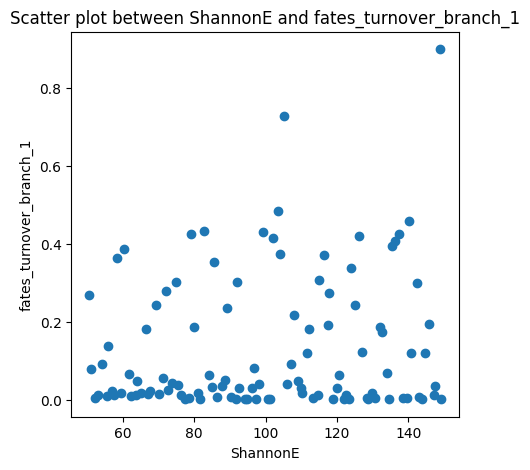

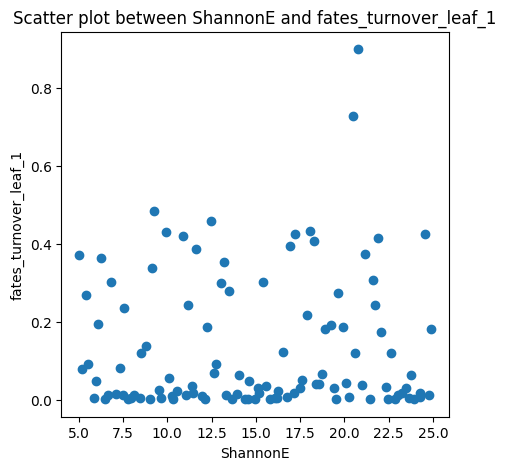

In [20]:
y_variable = 'ShannonE'

# Create a scatter plot for y_variable against each other variable
for col in cols_for_scatter:
    if col != y_variable:
        plt.figure(figsize=(5, 5))
        plt.scatter(df[col],df[y_variable])
        plt.title(f'Scatter plot between {y_variable} and {col}')
        plt.xlabel(y_variable)
        plt.ylabel(col)
        plt.show()